[<-- retour à l'index](../index.ipynb)

# Séries temporelles de température aux échelles annuelle, saisonnière et mensuelle en plusieurs points avec la réanalyse ERA5
Date: Février 2025  
Auteur: Martin Leduc

**Description**  
Affichage des séries temporelles de température aux échelles annuelle, saisonnière et mensuelle pour la réanalyse ERA5. Ce script permet de comparer les séries pour plusieurs points de grille définis par leur latitude et longitude.

© Copyright Ouranos Inc. and Martin Leduc 2025<br>
This work is licensed under [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Imports
import warnings
import numba

warnings.simplefilter("ignore", category=numba.core.errors.NumbaDeprecationWarning)

import intake
import xarray as xr
import xclim
from clisops.core import subset
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [2]:
# Charger les données
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5_NAM.ncml"
#ds = xr.open_dataset(url, chunks={"time": -1, "lat": 50, "lon": 50})
ds = xr.open_dataset(url, chunks={"time": (365*4)+1, "lat": 50, "lon": 50})
ds

<xarray.Dataset> Size: 116GB
Dimensions:  (lat: 320, lon: 680, time: 26571)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.25 10.5 10.75 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float32 3kB -179.9 -179.6 -179.4 ... -10.65 -10.4 -10.15
  * time     (time) datetime64[ns] 213kB 1950-01-01 1950-01-02 ... 2022-09-30
Data variables:
    tas      (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    pr       (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    prsn     (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
Attributes: (12/28)
    Conventions:          CF-1.9
    cell_methods:         time: mean (interval: 1 day)
    doi:                  https://doi.org/10.24381/cds.adbb2d47
    domain:               NAM
    frequency:            day
    history:              [2022-12-22 05:12:03.164107] Converted variables an...
    ...                   ...
    institute_id:         ECMWF
    dataset_id:           ERA5
    abstract:             ERA5 provides hourly estimates of a large number of...
    dataset_description:  https://www.ecmwf.int/en/forecasts/datasets/reanaly...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Copernicus Climate Change Service (C3S) (2017): ERA...

In [3]:
# Choisir les années à afficher, la coordonnée du point, et la variable 

# Années pour l'affichage (calculs effectués sur toute la période disponible)
debut,fin=1960, 2020

#ds = ds.tas.sel(time=slice(debut,fin))

# Entrer une série de coordonnées, format: [lat, lon, site]
ptinfos=[
#          [60, -73.56, 'Nunavik'],
#          [61.36, -57.78,  'Mer du Labrador'],
#          [58.77, -77.79, 'Inukjuak'],     
#          [58.099, -68.418,  'Kuujjuaq'],
#          [59.65991, -85.06750,  'Baie d\'Hudson'],
#          [59.62395, -67.57145,  'Baie d\'Ungava'],  

          [45.50, -73.56, 'Montreal'],  
          #[46.2885, -72.6955, 'Pointe-du-Lac'],
          [46.820634, -71.232010, 'Québec'],       
        ]

lats=[]
lons=[]
sites=[]
for ligne in ptinfos:
    lats.append(ligne[0])
    lons.append(ligne[1])
    sites.append(ligne[2])

pt = subset.subset_gridpoint(ds.tas, lon=lons, lat=lats)

# Ajouter la dimension "site"
if "site" not in pt.dims:
    pt = pt.expand_dims("site")

pt=pt.assign_coords(site=xr.DataArray(sites,dims="site"))

display(pt)

<xarray.DataArray 'tas' (time: 26571, site: 2)> Size: 213kB
dask.array<transpose, shape=(26571, 2), dtype=float32, chunksize=(1461, 2), chunktype=numpy.ndarray>
Coordinates:
    lat      (site) float32 8B 45.5 46.75
    lon      (site) float32 8B -73.65 -71.15
  * time     (time) datetime64[ns] 213kB 1950-01-01 1950-01-02 ... 2022-09-30
  * site     (site) <U8 64B 'Montreal' 'Québec'
Attributes:
    long_name:          2 metre temperature
    original_variable:  t2m
    standard_name:      air_temperature
    units:              K
    cell_methods:       time: point
    _ChunkSizes:        [365  50  50]

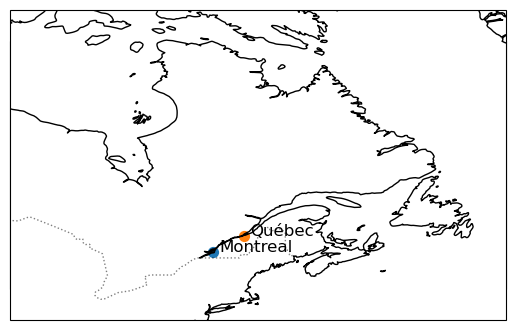

In [4]:
# Créer une figure et des axes avec une projection adaptée (ici, PlateCarree)
fig=plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Créer un axe avec une projection PlateCarree
ax = plt.axes(projection=ccrs.PlateCarree())

# Définir les limites de la carte pour englober la province de Québec
ax.set_extent([-90, -50, 40, 65], crs=ccrs.PlateCarree())  # [lon_min, lon_max, lat_min, lat_max]

# Ajouter des éléments géographiques : côtes, frontières, etc.
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)

for site in sites:
    # Tracer le point à partir des coordonnées du site (lon, lat)
    ptsite=pt.sel(site=site)
    ax.scatter(ptsite.lon, ptsite.lat, marker='o', s=50)

    # Ajouter un label au point
    ax.text(ptsite.lon + 0.5, ptsite.lat, ptsite.site.values, fontsize=12, ha='left', color='black')

# Afficher la carte
plt.show()

is## Moyennes annuelles

In [5]:
# Calcul de la série de moyennes annuelles
ser_ann = pt.groupby('time.year').mean()-273.15

#with ProgressBar():
with Client() as c:
    #display(c)    
    ser_ann.load()
ser_ann

<xarray.DataArray 'tas' (year: 73, site: 2)> Size: 584B
array([[6.097931 , 4.536499 ],
       [6.485901 , 4.7573547],
       [7.0065002, 5.2520447],
       [7.9579163, 6.056671 ],
       [6.0176086, 4.4566956],
       [6.693329 , 4.7886963],
       [5.803955 , 3.987915 ],
       [6.9911804, 4.976776 ],
       [5.9756775, 4.502899 ],
       [6.5845337, 4.6440735],
       [6.7917175, 5.10849  ],
       [6.414917 , 4.6865234],
       [5.6144104, 3.792511 ],
       [5.5556946, 3.842743 ],
       [6.564209 , 4.390564 ],
       [5.877411 , 3.7178955],
       [6.626465 , 4.9913635],
       [5.96579  , 4.0456543],
       [5.911682 , 4.3692017],
       [6.462372 , 4.9291077],
...
       [6.3393555, 4.649658 ],
       [6.370117 , 4.5440063],
       [7.3487244, 5.72583  ],
       [8.109222 , 6.604004 ],
       [6.900482 , 5.0041504],
       [6.966339 , 5.125702 ],
       [6.5891724, 4.947876 ],
       [8.466003 , 7.0054626],
       [7.891754 , 6.0366516],
       [8.330017 , 6.5264893],
       [7.194519 , 5.4322815],
       [6.890259 , 5.1704407],
       [7.182678 , 5.305603 ],
       [7.917633 , 5.8319397],
       [7.506256 , 5.57135  ],
       [7.2774353, 5.3110046],
       [6.491394 , 4.607025 ],
       [8.153381 , 6.0565796],
       [8.447174 , 6.6380005],
       [8.57489  , 6.8400574]], dtype=float32)
Coordinates:
    lat      (site) float32 8B 45.5 46.75
    lon      (site) float32 8B -73.65 -71.15
  * site     (site) <U8 64B 'Montreal' 'Québec'
  * year     (year) int64 584B 1950 1951 1952 1953 1954 ... 2019 2020 2021 2022

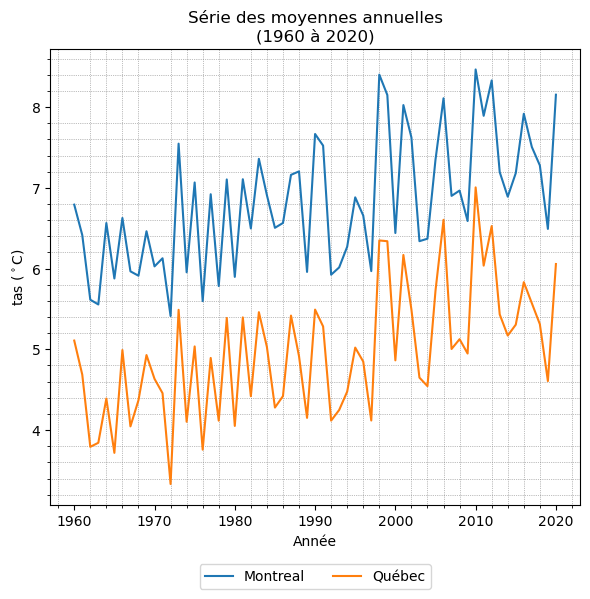

In [6]:
fig = plt.figure(figsize=(6, 6))

# Affichage des sếries
for nom_site in sites:
    plt.plot(ser_ann.year.sel(year=slice(debut,fin)),ser_ann.sel(site=nom_site,year=slice(debut,fin)),label=nom_site)
    #plt.ylim(-5,6)                                              # Fixer les bornes de l'axe vertical

plt.title('Série des moyennes annuelles\n('+str(debut)+' à '+str(fin)+')')

# Ajout du quadrillage secondaire
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()  # Active les graduations mineures

# Titres axes
plt.xlabel("Année")
plt.ylabel("tas ($^\circ$C)")



plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))
plt.subplots_adjust(bottom=0.2)  # laisser de l'espace en bas        
   
plt.tight_layout()

In [7]:
## Moyennes saisonnières

In [8]:
# Calcul de la série de moyennes saisonnières
ser_sais = pt.groupby(["time.season","time.year"]).mean() -273.15

#with ProgressBar():
with Client() as c:
    #display(c)    
    ser_sais.load()
ser_sais

<xarray.DataArray 'tas' (season: 4, year: 73, site: 2)> Size: 2kB
array([[[ -7.6073303,  -9.406982 ],
        [ -7.5279846,  -9.0979   ],
        [ -6.425873 ,  -8.068268 ],
        [ -4.8914795,  -6.667633 ],
        [ -8.387939 ,  -8.875366 ],
        [-10.153198 , -10.827423 ],
        [ -6.6874084,  -7.901245 ],
        [ -7.654907 ,  -9.524872 ],
        [-10.409424 , -10.980469 ],
        [ -9.227356 , -10.473572 ],
        [ -7.39859  ,  -8.303925 ],
        [ -8.602814 , -10.317169 ],
        [ -9.908386 , -11.544586 ],
        [-11.380341 , -12.725372 ],
        [ -6.808655 ,  -8.560944 ],
        [ -8.192474 , -10.490326 ],
        [ -7.6312866,  -8.081512 ],
        [ -7.8004456, -10.332733 ],
        [-11.211945 , -12.23465  ],
        [ -7.481415 ,  -7.995758 ],
...
        [  9.398224 ,   7.581848 ],
        [  9.142395 ,   7.3793945],
        [ 10.205353 ,   8.238953 ],
        [  9.230133 ,   7.8545227],
        [  9.871155 ,   7.910187 ],
        [  9.085266 ,   7.3880005],
        [  8.841827 ,   7.1422424],
        [  9.16983  ,   7.3693542],
        [ 10.860474 ,   8.935394 ],
        [  9.033478 ,   7.60553  ],
        [  9.000488 ,   7.3624268],
        [  9.70752  ,   7.618805 ],
        [ 10.413818 ,   8.408813 ],
        [ 10.318268 ,   8.556641 ],
        [ 10.768433 ,   8.750702 ],
        [  8.014862 ,   5.716217 ],
        [  8.1744995,   6.147522 ],
        [  9.404327 ,   7.2962646],
        [ 10.489807 ,   8.769165 ],
        [ 15.519012 ,  14.072296 ]]], dtype=float32)
Coordinates:
    lat      (site) float32 8B 45.5 46.75
    lon      (site) float32 8B -73.65 -71.15
  * site     (site) <U8 64B 'Montreal' 'Québec'
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * year     (year) int64 584B 1950 1951 1952 1953 1954 ... 2019 2020 2021 2022

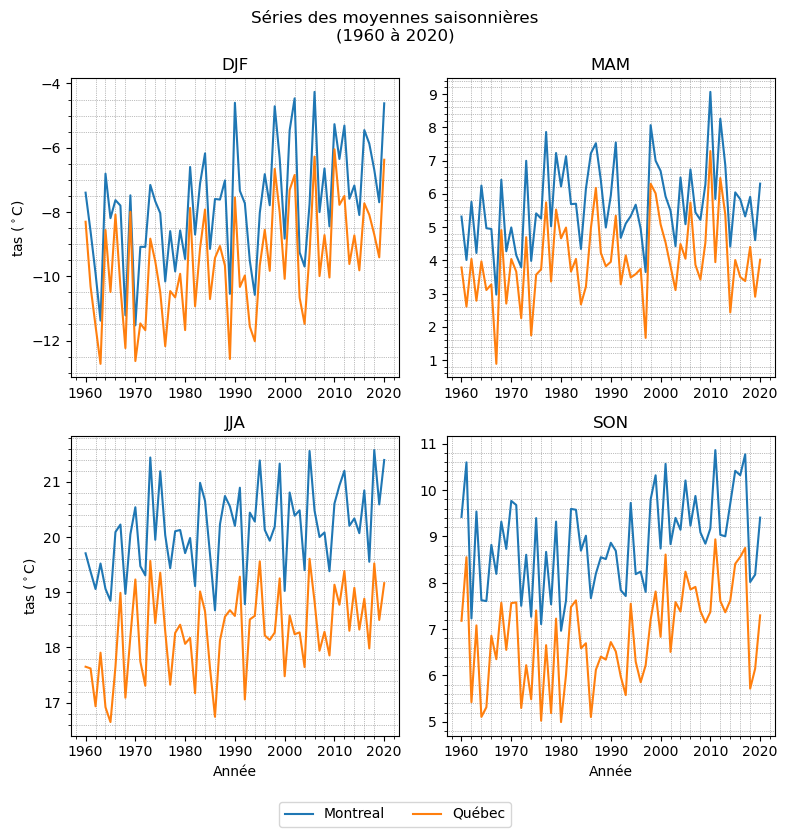

In [9]:
# Affichage des séries

fig,axes = plt.subplots(2,2,figsize=(8, 8))
axes = axes.ravel()               

for jj,sais in enumerate(['DJF','MAM','JJA','SON']):
    # Afficher la variable
    for nom_site in sites:
        p=axes[jj].plot(ser_sais.sel(season=sais,year=slice(debut, fin)).year,ser_sais.sel(site=nom_site,season=sais,year=slice(debut, fin)),label=nom_site)
    
    # Titres panneaux
    axes[jj].title.set_text(sais)
    #axes[jj].set_ylim(-5,5)                      # Fixer les bornes de l'axe vertical

    # Quadrillage
    axes[jj].minorticks_on()  # Active les graduations mineures
    axes[jj].grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')
    
    # Titres axes
    if jj in [0,2]:
        axes[jj].set_ylabel("tas ($^\circ$C)")
    if jj in [2,3]:
        axes[jj].set_xlabel("Année")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.subplots_adjust(bottom=0.2)  # laisser de l'espace en bas        
plt.suptitle('Séries des moyennes saisonnières\n('+str(debut)+' à '+str(fin)+')')
plt.tight_layout()

## Moyennes mensuelles

In [10]:
# Calcul de la série de moyennes mensuelles
ser_mois = pt.groupby(["time.month","time.year"]).mean() -273.15

#with ProgressBar():
with Client() as c:
    #display(c)    
    ser_mois.load()
ser_mois

<xarray.DataArray 'tas' (month: 12, year: 73, site: 2)> Size: 7kB
array([[[ -6.1176147 ,  -9.302521  ],
        [ -8.417511  ,  -9.759216  ],
        [ -9.02063   , -11.049774  ],
        ...,
        [ -5.8279114 ,  -7.6123047 ],
        [ -6.7097473 ,  -7.4193726 ],
        [-13.515198  , -14.522461  ]],

       [[-10.7204895 , -12.209442  ],
        [ -7.9431458 ,  -8.651093  ],
        [ -5.995056  ,  -7.067627  ],
        ...,
        [ -6.23761   ,  -7.930786  ],
        [ -7.9277344 ,  -8.709412  ],
        [ -7.74234   ,  -9.547028  ]],

       [[ -5.9081116 ,  -6.7931213 ],
        [ -1.3337097 ,  -2.6503906 ],
        [ -2.2234802 ,  -2.715454  ],
        ...,
...
        ...,
        [  8.860474  ,   6.6821594 ],
        [ 11.66156   ,   9.942413  ],
        [         nan,          nan]],

       [[  3.4497986 ,   1.8630981 ],
        [ -0.44665527,  -2.6600952 ],
        [  2.8186035 ,   0.3045044 ],
        ...,
        [  4.654022  ,   2.202942  ],
        [  2.716217  ,   1.1882019 ],
        [         nan,          nan]],

       [[ -6.285187  ,  -6.9802246 ],
        [ -6.2634277 ,  -8.840179  ],
        [ -4.2341614 ,  -6.0227966 ],
        ...,
        [ -1.8963623 ,  -3.6812744 ],
        [ -3.0318909 ,  -6.5522766 ],
        [         nan,          nan]]], dtype=float32)
Coordinates:
    lat      (site) float32 8B 45.5 46.75
    lon      (site) float32 8B -73.65 -71.15
  * site     (site) <U8 64B 'Montreal' 'Québec'
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 584B 1950 1951 1952 1953 1954 ... 2019 2020 2021 2022

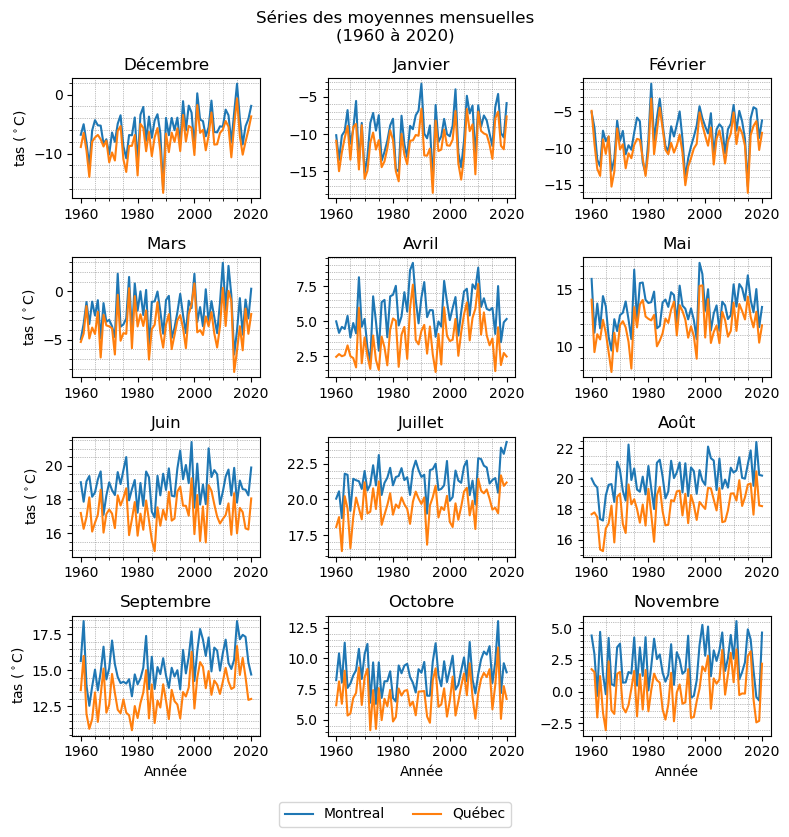

In [11]:
# Affichage des séries

# Liste des mois
mois_num=[12,1,2,3,4,5,6,7,8,9,10,11]
mois_nom=['Décembre','Janvier','Février','Mars','Avril','Mai','Juin','Juillet','Août','Septembre','Octobre','Novembre']

# Graphiques
fig,axes = plt.subplots(4,3,figsize=(8, 8))
axes = axes.ravel()               

for jj,mois in enumerate(mois_num):
    # Afficher la variable
    for nom_site in sites:
        p=axes[jj].plot(ser_mois.sel(month=mois,year=slice(debut, fin)).year,ser_mois.sel(site=nom_site,month=mois,year=slice(debut, fin)),label=nom_site)

    # Titres panneaux
    axes[jj].title.set_text(mois_nom[jj])
    #axes[jj].set_ylim(-10,10)                      # Fixer les bornes de l'axe vertical

    # Ajout du quadrillage secondaire
    axes[jj].minorticks_on()  # Active les graduations mineures
    axes[jj].grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')
    
    # Titres axes
    if jj in [0,3,6,9]:
        axes[jj].set_ylabel("tas ($^\circ$C)")
    if jj in [9,10,11]:
        axes[jj].set_xlabel("Année")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.subplots_adjust(bottom=0.2)  # laisser de l'espace en bas        
plt.suptitle('Séries des moyennes mensuelles\n('+str(debut)+' à '+str(fin)+')')
plt.tight_layout()